## Reload the `EC_estimator.py` code to consider any changes

In [1]:
#reload model magic
%load_ext autoreload
%autoreload 2

import EC_estimator as annec

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [3]:
tf.__version__

'2.2.0'

## Load the dataset, preprocessing, and apply ANN model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import EC_estimator as annec

# ------------------------------------------------------------
# Settings
# ------------------------------------------------------------
predictors = ["dcc", "exports", "sac", "sjr", "tide", "net_dcd", "smscg"]
target = "EC"
WINDOW = 118  # 1 + 7 + (10*11)

test_start  = "1923-01-01"
test_end    = "1939-12-31"
train_start = "1940-01-01"
train_end   = "2015-12-31"


# ------------------------------------------------------------
# Helper: create sliding windows
# ------------------------------------------------------------
def make_windows(df_raw: pd.DataFrame, predictors, target, window: int):
    """
    Builds:
      X_seq: (N, window, n_predictors)
      y:     (N, 1)

    Backward alignment:
      window rows are [t-window+1, ..., t]  (history ending at t)
      y is df_raw[target].iloc[t]
    """
    X_all = df_raw[predictors].to_numpy()
    y_all = df_raw[target].to_numpy().reshape(-1, 1)

    if len(df_raw) < window:
        raise ValueError(f"Not enough rows ({len(df_raw)}) to build a window of {window}.")

    Xw = []
    yw = []

    # t is the "current day" index
    for t in range(window - 1, len(df_raw)):
        Xw.append(X_all[t - window + 1 : t + 1, :])  # (window, n_predictors), ends at t
        yw.append(y_all[t])                          # target at t

    X_seq = np.stack(Xw, axis=0)
    y = np.vstack(yw)
    return X_seq, y



# ------------------------------------------------------------
# Load raw daily data (date + 7 predictors + EC)
# ------------------------------------------------------------
df = annec.load_data("Inputs/EC_inputs.csv")

df["date"] = pd.to_datetime(df["date"], errors="raise")
df = df.sort_values("date")

# Keep date for splitting; do NOT convert to MultiIndex lags
df = df.reset_index(drop=True)

# Sanity check columns
missing_cols = [c for c in (["date"] + predictors + [target]) if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in EC_inputs.csv: {missing_cols}")


# ------------------------------------------------------------
# Split by date ranges on raw data
# ------------------------------------------------------------
df_test_raw  = df[(df["date"] >= test_start) & (df["date"] <= test_end)].copy()
df_train_raw = df[(df["date"] >= train_start) & (df["date"] <= train_end)].copy()

if df_test_raw.empty:
    raise ValueError("df_test_raw is empty. Check that dates exist in 1923–1939.")
if df_train_raw.empty:
    raise ValueError("df_train_raw is empty. Check that dates exist in 1940–2015.")

print("Train:", df_train_raw["date"].min().date(), "→", df_train_raw["date"].max().date(), "rows:", len(df_train_raw))
print("Test :", df_test_raw["date"].min().date(),  "→", df_test_raw["date"].max().date(),  "rows:", len(df_test_raw))


# ------------------------------------------------------------
# Build raw windows (118 days × 7 predictors)
# ------------------------------------------------------------
X_train_seq, y_train_arr = make_windows(df_train_raw, predictors, target, WINDOW)
X_test_seq,  y_test_arr  = make_windows(df_test_raw,  predictors, target, WINDOW)

# Convert to "7 inputs" format: each is (N,118)
X_train = [X_train_seq[:, :, i] for i in range(len(predictors))]
X_test  = [X_test_seq[:, :, i]  for i in range(len(predictors))]

# Targets as DataFrame (keeps your existing train_model interface happy)
y_train = pd.DataFrame(y_train_arr, columns=[target])
y_test  = pd.DataFrame(y_test_arr,  columns=[target])

print("X_train shapes:", [x.shape for x in X_train])  # expect 7 × (N,118)
print("y_train shape :", y_train.shape)
print(f"y_train range: [{y_train.values.min():.1f}, {y_train.values.max():.1f}]")
print(f"y_test range:  [{y_test.values.min():.1f}, {y_test.values.max():.1f}]")


# ------------------------------------------------------------
# Scale targets to [0.1, 0.9] (matching original annutilsr approach)
# ------------------------------------------------------------
y_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
y_scaler.fit(y_train)  # Fit on training data ONLY (no leakage)

y_train_scaled = pd.DataFrame(
    y_scaler.transform(y_train), 
    index=y_train.index, 
    columns=y_train.columns
)
y_test_scaled = pd.DataFrame(
    y_scaler.transform(y_test), 
    index=y_test.index, 
    columns=y_test.columns
)

print(f"\nScaled y_train range: [{y_train_scaled.values.min():.4f}, {y_train_scaled.values.max():.4f}]")
print(f"Scaled y_test range:  [{y_test_scaled.values.min():.4f}, {y_test_scaled.values.max():.4f}]")


# ------------------------------------------------------------
# Build model (inputs are now raw 118-day vectors)
# ------------------------------------------------------------
# Build model inputs (should create 7 Input(shape=(118,), ...))
inputs = annec.build_model_inputs(None)

# Preprocessing layers:
# IMPORTANT: normalize using TRAIN only (no leakage).
layers = annec.preprocessing_layers(df_train_raw, inputs, X_train)

neurons = [8, 2, 1]
activations = ["sigmoid", "sigmoid"]
model, tensorboard_cb = annec.build_model(layers, inputs)

print("\nModel summary:")
model.summary()


# ------------------------------------------------------------
# Train with SCALED targets
# ------------------------------------------------------------
history, model = annec.train_model(
    model, tensorboard_cb, 
    X_train, y_train_scaled,   # Use scaled targets
    X_test, y_test_scaled,     # Use scaled validation targets
    epochs=10000,
    patience=1000,
    batch_size=128
)

Train: 1940-01-01 → 2015-09-29 rows: 27666
Test : 1923-04-28 → 1939-12-31 rows: 6092
X_train shapes: [(27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118)]
y_train shape : (27549, 1)


## Evaluation of the model

In [ ]:
# Calculate metrics for ANN
# Model outputs are in SCALED space [0.1, 0.9], so inverse-transform to original EC units

metrics = []

# Predict (scaled outputs)
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_test_pred_scaled  = model.predict(X_test, verbose=0)

# Inverse-transform to original EC units
y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
y_test_pred  = y_scaler.inverse_transform(y_test_pred_scaled)

print("=== Predictions (original EC units, last 3 samples) ===")
print("train:", y_train_pred[-3:].ravel())
print("test :", y_test_pred[-3:].ravel())

print("\n=== Scaled predictions range ===")
print(f"y_train_pred_scaled: [{y_train_pred_scaled.min():.4f}, {y_train_pred_scaled.max():.4f}]")
print(f"y_test_pred_scaled:  [{y_test_pred_scaled.min():.4f}, {y_test_pred_scaled.max():.4f}]")

# Compute metrics using original (unscaled) values
y_train_true = y_train.values  # Original EC values
y_test_true  = y_test.values   # Original EC values

metrics.append(
    annec.calculate_metrics("ANN", y_train, y_train_pred, y_test, y_test_pred)
)

df3 = pd.DataFrame(metrics)
print("\n=== Model Performance ===")
print(df3)

predictions (last 3)
train: [621.57764 621.57764 621.57764]
test : [621.57764 621.57764 621.57764]

inputs (feature 0 = dcc) last 3 windows, first 10 values of each window:
train dcc: [[26. 26. 26. 26. 26. 26. 26. 26. 26. 26.]
 [26. 26. 26. 26. 26. 26. 26. 26. 26. 26.]
 [26. 26. 26. 26. 26. 26. 26. 26. 26. 26.]]
test  dcc: [[30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]]
  Model  Train_R2  Train_RMSE  Train_Percentage_Bias  Test_R2  Test_RMSE  \
0   ANN     -0.02      877.63                  90.42    -0.24     1216.5   

   Test_Percentage_Bias  
0                 39.48  


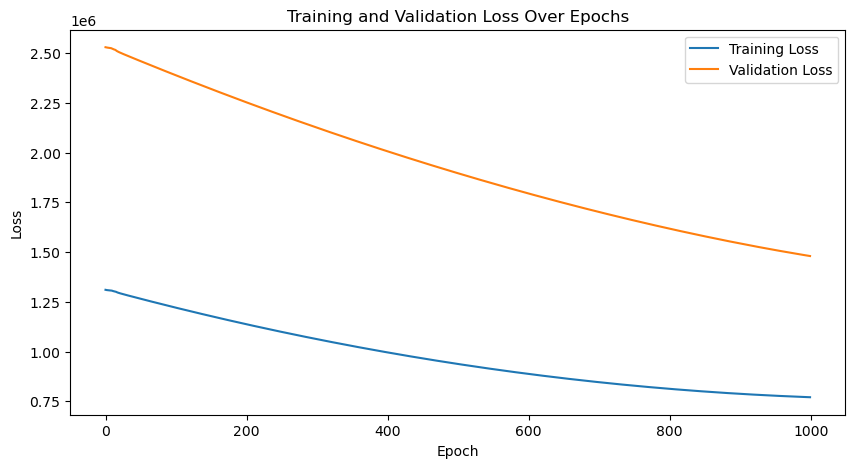

In [7]:
annec.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

0    2134.271484
Name: 5974, dtype: float32


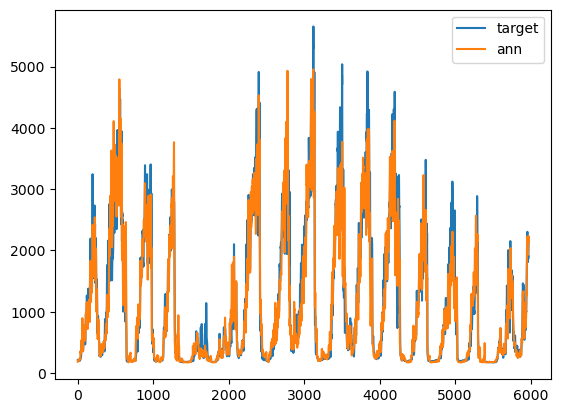

In [ ]:
# Plot predictions vs actual (in original EC units)
import matplotlib.pyplot as plt

ax = y_test.plot(label='target')
pred = pd.DataFrame(index=y_test.index, data=y_test_pred, columns=['prediction'])
print(f"Last prediction: {pred.iloc[-1].values[0]:.1f}")
pred.plot(ax=ax)
plt.ylabel('EC')
plt.legend(["target", "ann"])
plt.title('Test Set: ANN Prediction vs Target')
plt.show()

## Save the final model

In [ ]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

model_save_path = r'./Export/emmaton'
annec.save_model(model, model_save_path)

# Save the y_scaler for inference (needed to inverse-transform predictions)
import os
scaler_path = os.path.join(model_save_path, 'y_scaler.pkl')
annec.save_scaler(y_scaler, scaler_path)
print(f"y_scaler saved at: {scaler_path}")

INFO:tensorflow:Assets written to: ./Export/emmaton\assets
Model saved at location: ./Export/emmaton


dd

In [ ]:
# Load saved model and evaluate
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})

# Load the y_scaler
import os
scaler_path = os.path.join(model_save_path, 'y_scaler.pkl')
y_scaler_loaded = annec.load_scaler(scaler_path)

# Calculate metrics for ANN
metrics = []

# Predict (scaled) and inverse-transform
y_train_pred_scaled = loaded_model.predict(X_train, verbose=0)
y_test_pred_scaled  = loaded_model.predict(X_test, verbose=0)

y_train_pred = y_scaler_loaded.inverse_transform(y_train_pred_scaled)
y_test_pred  = y_scaler_loaded.inverse_transform(y_test_pred_scaled)

metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))

+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |       0.98 |       129.29 |                    3.75 |      0.93 |       287.8 |                   3.61 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process, so the above example should cover it.

In [37]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for 

df_sample = pd.read_csv("Inputs/EC_inputs_antecedents_ordered_with_output.csv", header=None)
input_sample = [frame.to_frame().to_numpy().transpose() for ndx,frame in df_sample.iterrows()] 
print("Sample")
print(input_sample)
y_sample_pred = loaded_model.predict(input_sample)
print(y_sample_pred)





[autoreload of tensorflow.python.keras.layers.core failed: Traceback (most recent call last):
  File "c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\importlib\__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module EC_estimator not in sys.modules
]


FileNotFoundError: [Errno 2] No such file or directory: 'Inputs/EC_inputs_antecedents_ordered_with_output.csv'